RETFound_MAE Fundus + OCT Inference & Analysis
This notebook-style script loads a pretrained RETFound_MAE model, runs inference on fundus images,
visualizes metrics in real time, logs results to CSV with timestamps, and provides sample outputs.

In [1]:
# 1) Install dependencies (if missing)
import os, sys
try:
    import torch, torchvision, timm, gdown, pandas as pd, numpy as np, matplotlib, seaborn, sklearn
    from tqdm import tqdm
except ImportError:
    os.system(f"{sys.executable} -m pip install --quiet torch torchvision timm gdown pandas numpy matplotlib seaborn scikit-learn tqdm")
    import torch, torchvision, timm, gdown, pandas as pd, numpy as np, matplotlib, seaborn, sklearn
    from tqdm import tqdm

In [3]:
# 2) Clone RETFound_MAE and ensure weights exist
def ensure_repo(name, url):
    if not os.path.isdir(name):
        print(f"Cloning {name}...")
        os.system(f"git clone {url} {name}")

ensure_repo("RETFound_MAE", "https://huggingface.co/open-eye/RETFound_MAE")
sys.path.append(os.path.join(os.getcwd(), "RETFound_MAE"))

WEIGHTS = "RETFound_cfp_weights.pth"
if not os.path.isfile(WEIGHTS):
    print("Downloading pretrained fundus weights...")
    os.system(f"gdown --quiet --id 1l62zbWUFTlp214SvK6eMwPQZAzcwoeBE -O {WEIGHTS}")
print("✔︎ Model weights ready:", WEIGHTS)

✔︎ Model weights ready: RETFound_cfp_weights.pth


In [4]:
# 3) Load model architecture and weights
import torch
import models_vit
from util.pos_embed import interpolate_pos_embed
from timm.layers import trunc_normal_

# determine num_classes from dataset folder (if exists)
DATA_DIR = "color_fundus_eye/color_fundus_eye"
train_dir = os.path.join(DATA_DIR, "train")
if os.path.isdir(train_dir):
    classes = sorted(os.listdir(train_dir))
    num_classes = len(classes)
else:
    raise FileNotFoundError(f"Training folder not found: {train_dir}")
print(f"Detected {num_classes} classes: {classes}")

# instantiate and load
ckpt = torch.load(WEIGHTS, map_location="cpu", weights_only=False)
ckpt_model = ckpt['model']
model = models_vit.__dict__['vit_large_patch16'](num_classes=num_classes, drop_path_rate=0.2)
state = model.state_dict()
for k in ['head.weight','head.bias']:
    if k in ckpt_model and ckpt_model[k].shape != state[k].shape:
        del ckpt_model[k]
interpolate_pos_embed(model, ckpt_model)
msg = model.load_state_dict(ckpt_model, strict=False)
print("Loaded model, missing keys:", msg.missing_keys)
if 'head.weight' in msg.missing_keys:
    trunc_normal_(model.head.weight, std=2e-5)
model.eval()

Detected 10 classes: ['Central Serous Chorioretinopathy [Color Fundus]', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']


KeyboardInterrupt: 

In [4]:
# 4) Prepare DataLoaders with progress and exception handling
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

print("Setting up DataLoaders...")
try:
    train_ds = ImageFolder(train_dir, transform=transform)
    test_ds = ImageFolder(os.path.join(DATA_DIR, 'test'), transform=transform)
except Exception as e:
    raise RuntimeError("Failed to load datasets: " + str(e))

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)
print(f"Train samples: {len(train_ds)}, Test samples: {len(test_ds)}")

Setting up DataLoaders...
Train samples: 12989, Test samples: 3253


In [5]:
# 5) Fine-tuning / Inference loop with tqdm progress
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)

epochs = 5
history = {'train_loss': [], 'test_acc': []}
for epoch in range(1, epochs+1):
    # Training pass (just record loss)
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(avg_loss)
    print(f"Epoch {epoch} — Avg Train Loss: {avg_loss:.4f}")

    # Validation pass
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc=f"Epoch {epoch}/{epochs} eval", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    history['test_acc'].append(acc)
    print(f"Epoch {epoch} — Test Acc: {acc:.4%}")

Epoch 1 — Avg Train Loss: 1.4026


Epoch 1 — Test Acc: 71.8106%


Epoch 2 — Avg Train Loss: 0.6824


Epoch 2 — Test Acc: 80.7870%


Epoch 3 — Avg Train Loss: 0.4857


Epoch 3 — Test Acc: 80.2951%


Epoch 4 — Avg Train Loss: 0.3915


Epoch 4 — Test Acc: 83.9225%


Epoch 5 — Avg Train Loss: 0.3232


Epoch 5 — Test Acc: 83.9225%


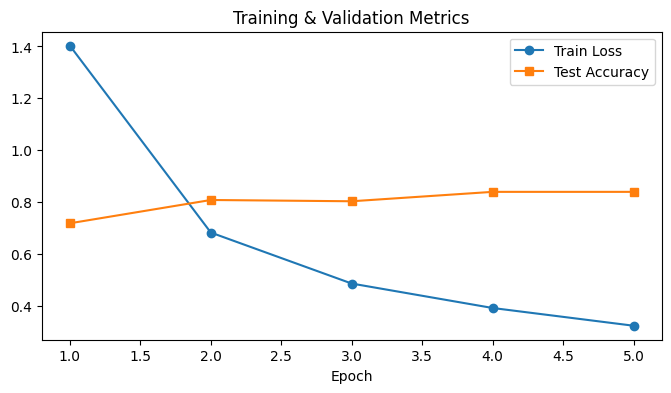

In [6]:
# 6) Visualize learning curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(range(1,epochs+1), history['train_loss'], marker='o', label='Train Loss')
plt.plot(range(1,epochs+1), history['test_acc'], marker='s', label='Test Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training & Validation Metrics')
plt.show()

Classification Report:
                                                  precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       0.80      0.84      0.82       122
                           Diabetic Retinopathy       0.96      0.96      0.96       689
                                     Disc Edema       0.97      0.91      0.94       153
                                       Glaucoma       0.68      0.79      0.73       576
                                        Healthy       0.82      0.73      0.77       536
                                   Macular Scar       0.79      0.78      0.79       388
                                         Myopia       0.87      0.79      0.83       451
                                      Pterygium       1.00      1.00      1.00        21
                             Retinal Detachment       0.99      0.90      0.94       150
                           Retinitis Pigmentosa       0.85      0.98      0.91       

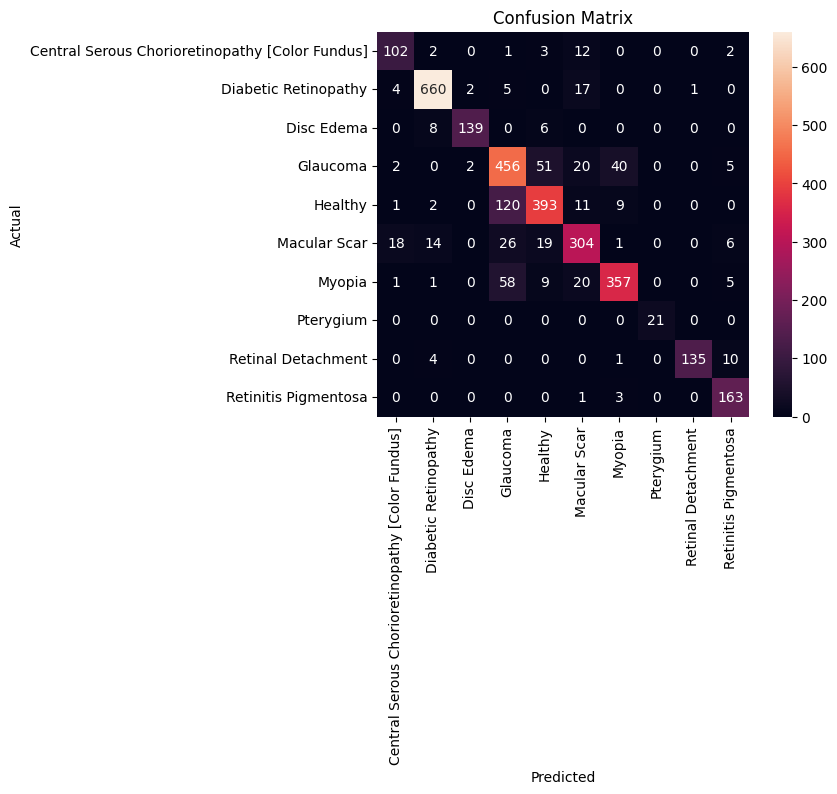

In [7]:
# 7) Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# gather full test predictions
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        preds = model(imgs).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=classes))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# 8) Save history and metrics to CSV with timestamp
import pandas as pd
from datetime import datetime

df = pd.DataFrame({
    'epoch': list(range(1, epochs+1)),
    'train_loss': history['train_loss'],
    'test_acc': history['test_acc'],
})
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
fname = f"fundus_metrics_{timestamp}.csv"
df.to_csv(fname, index=False)
print(f"Saved metrics to {fname}")

Saved metrics to fundus_metrics_20250420_105251.csv


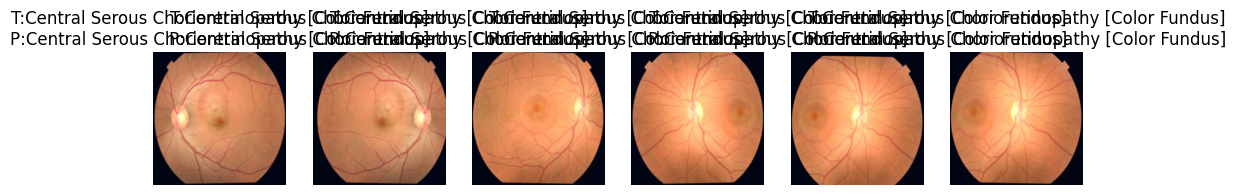

In [9]:
# 9) Sample Inference Visualizations
def show_samples(loader, n=6):
    imgs, labels = next(iter(loader))
    imgs, labels = imgs[:n], labels[:n]
    preds = model(imgs.to(device)).argmax(dim=1).cpu()
    imgs = imgs.permute(0,2,3,1).numpy()
    fig, axes = plt.subplots(1, n, figsize=(12,3))
    for i, ax in enumerate(axes):
        ax.imshow((imgs[i]*0.229+0.485).clip(0,1))
        ax.axis('off')
        ax.set_title(f"T:{classes[labels[i]]}\nP:{classes[preds[i]]}")
    plt.show()

show_samples(test_loader)